In [206]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
from statistics import mean
from scipy.optimize import curve_fit
import imageio
from pathlib import Path
import warnings

In [207]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

mask = create_circular_mask(256, 320, center=None, radius=120);

In [208]:
#Plotting Options
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"

In [209]:
file_path = '/Volumes/KESU/IRCAM_data/jul072021/images/'
name = "hair1.h5"

def keys(f):
    return [key for key in f.keys()]

In [367]:
name = "/Volumes/KESU/IRCAM_data/jun282021/palm1.h5"

hf = h5py.File(name, 'r')
imgs = np.array(hf['imgs'])
#ts  = np.array(hf['temps'])
#ans = np.array(hf['set_angels'])
print(hf.keys())
hf.close()

hf = h5py.File('/Volumes/KESU/IRCAM_data/jun282021/cold_vert1.h5', 'r')
dark = np.array(hf['dark'])
hf.close()

<KeysViewHDF5 ['actual_angles', 'dark', 'imgs', 'set_angels', 'temps', 'temps_dark']>


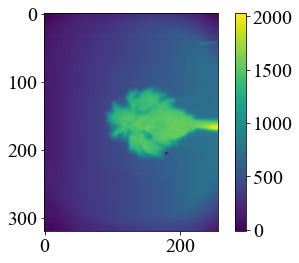

In [368]:
plt.imshow(np.transpose(np.mean(imgs[[1]],axis = 0)-dark[1]))
plt.colorbar()

In [369]:
ims = []
for i in range(len(imgs)):
    img_mask = (imgs[i]- dark[i])*mask
    img_mask[img_mask == 0] = 'nan' 
    ims.append(img_mask)
    imgs[i] = imgs[i]- dark[i]
    
imgs[imgs < 0] = 0

S0 = np.sum(imgs,axis = 0)/2
S1 = imgs[0]-imgs[2]
S2 = imgs[1]-imgs[3]

s1 = S1/S0
s2 = S2/S0

DOLP = 100*np.sqrt(S1**2+S2**2)/S0
AOLP = (180/(2*np.pi)*(np.arctan2(S2,S1)))

/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [370]:
vmax = np.nanmax(ims[0])
vmin = np.nanmin(ims[0])
s1vmax = np.max(np.abs(S1))
s2vmax = np.max(np.abs(S2))

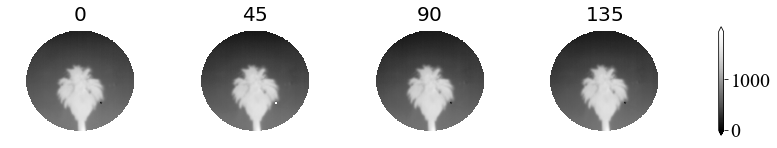

[32.7 32.7 32.7 32.8]


In [371]:
fig, axes = plt.subplots(figsize=(15, 2), ncols=4)

# STOKES IMAGES
# color "mappable" object returned by ax1.imshow
pos1 = axes[0].imshow(ims[0], cmap='Greys_r', aspect='auto')
#fig.colorbar(pos1, ax=ax1,extend='both',label = "ADU")
axes[0].set_title("$0$",fontsize = 20)
axes[0].axis('off')
    
pos2 = axes[1].imshow(ims[1], cmap='Greys_r', aspect='auto')
#fig.colorbar(pos2, ax=ax2,extend='both')
axes[1].set_title("$45$",fontsize = 20)
axes[1].axis('off')

pos3 = axes[2].imshow(ims[2], cmap='Greys_r', aspect='auto')
#fig.colorbar(pos3, ax=ax3,extend='both')
axes[2].set_title("$90$",fontsize = 20)
axes[2].axis('off')

pos4 = axes[3].imshow(ims[3], cmap='Greys_r', aspect='auto')
axes[3].set_title("$135$",fontsize = 20)
axes[3].axis('off')

fig.colorbar(pos1, ax=axes.ravel().tolist(), extend='both')
#fig.savefig( '/Volumes/KESU/IRCAM_data/imgs/flux_'+name[:-3]+'.png')

plt.show()

print(ts)

/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


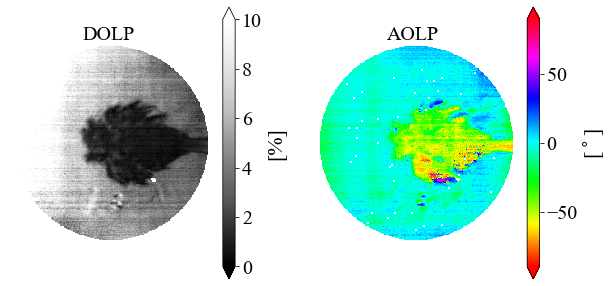

In [372]:
#set clim for S0 image
S0mean = np.mean(S0)
S0std  = np.std(S0)
dev = 3
    
s1m = np.max(np.abs(S1/S0))
s2m = np.max(np.abs(S2/S0)) 
dolp = DOLP*mask
aolp = AOLP*mask
dolp[dolp == 0] = 'nan' 
aolp[aolp == 0] = 'nan' 
    
#AOLP DOLP
fig, (ax2, ax3) = plt.subplots(figsize=(10, 5), ncols=2)
# plot just the positive data and save the
# color "mappable" object returned by ax1.imshow


pos2 = ax2.imshow(np.transpose(dolp[0:250,40:280]), cmap='Greys_r',vmin = 0,vmax =10)
fig.colorbar(pos2, ax=ax2,extend='both',label = '[%]')
ax2.set_title("DOLP",fontsize = 20)
ax2.axis('off')

pos3 = ax3.imshow( np.transpose(aolp[0:250,40:280]), cmap='hsv')
fig.colorbar(pos3, ax=ax3,extend='both',label = "[$^\circ$]")
ax3.set_title("AOLP",fontsize = 20)
ax3.axis('off')
plt.show()
#fig.savefig( '/Volumes/KESU/IRCAM_data/imgs/daolp_'+name[:-3]+'.png')
    

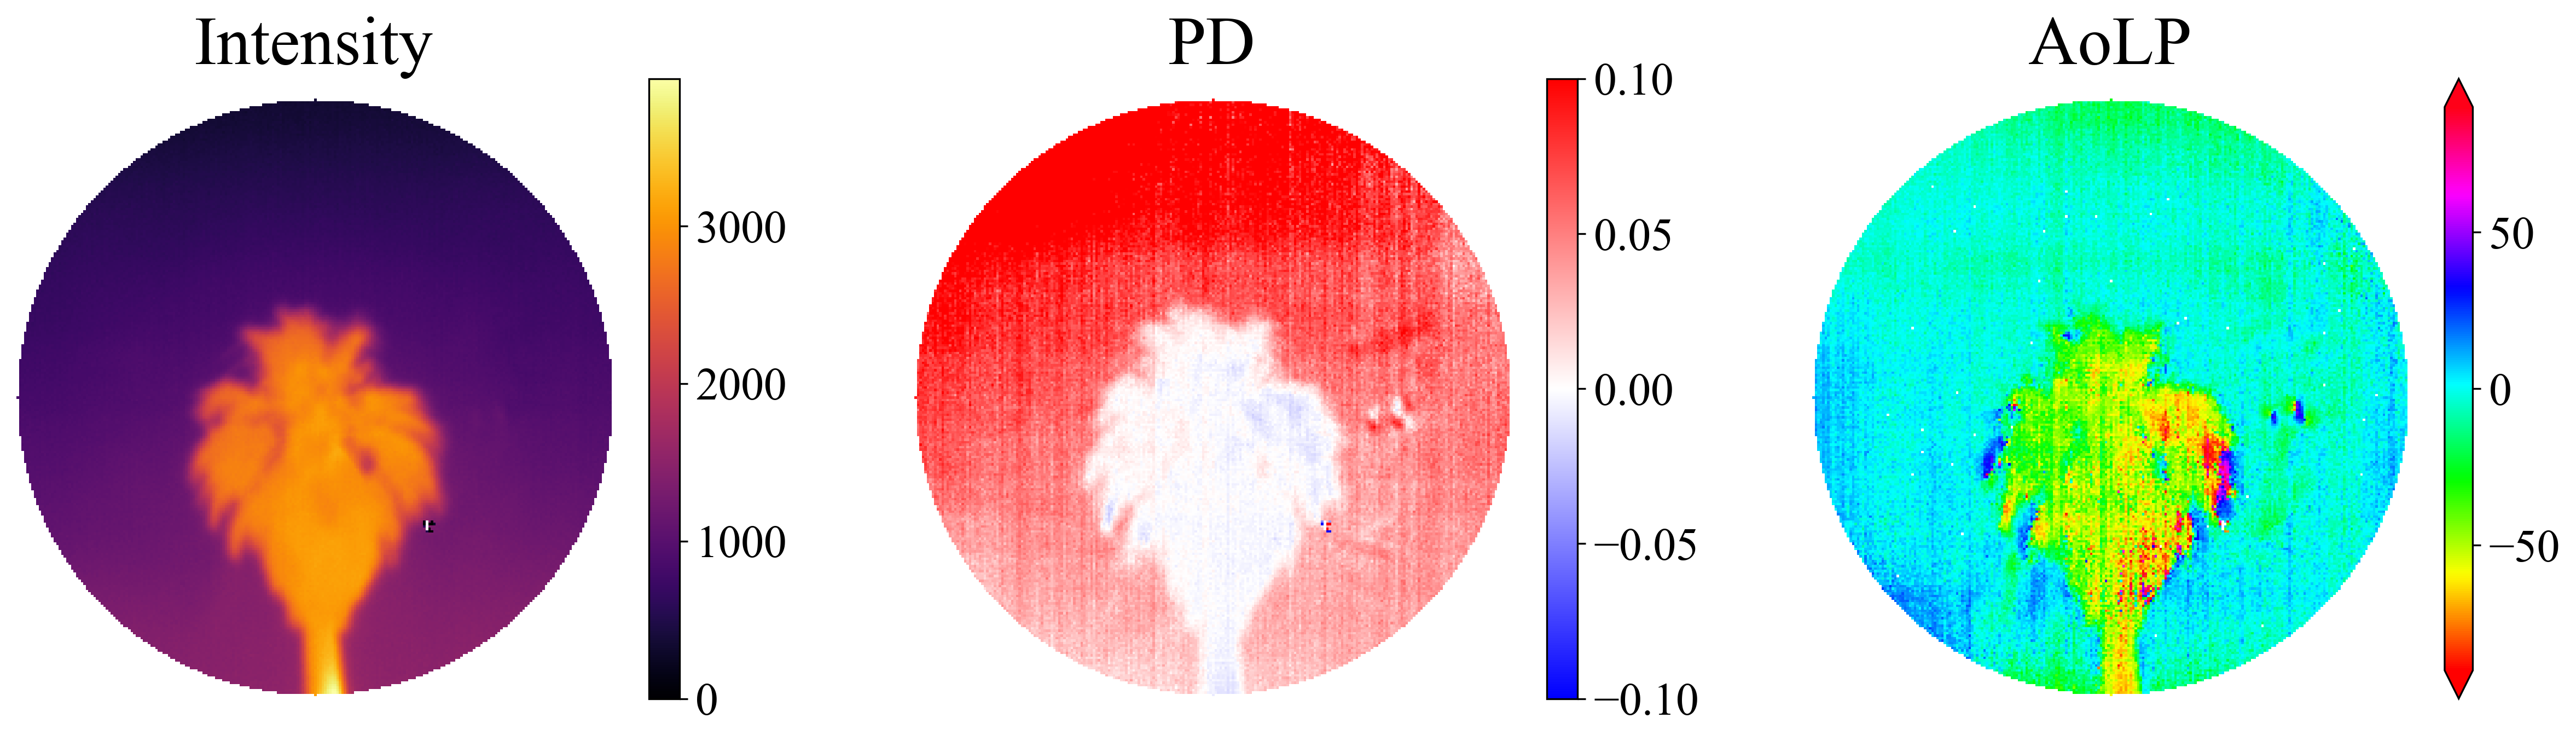

In [376]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 5), ncols=3)

# STOKES IMAGES
# color "mappable" object returned by ax1.imshow
S0_mask =S0*mask;
S0_mask[S0_mask == 0] = 'nan' 
pos1 = ax1.imshow(S0_mask[0:250,40:280], cmap='inferno',vmin =0)
fig.colorbar(pos1, ax=ax1)
ax1.set_title("Intensity",fontsize = 30)
ax1.axis('off')
    
lim = .1;
pos2 = ax2.imshow((S1*mask)[0:250,40:280]/(S0_mask[0:250,40:280]), cmap='bwr', vmin =-lim,vmax =lim )
fig.colorbar(pos2, ax=ax2)
ax2.set_title("PD",fontsize = 30)
ax2.axis('off')

pos3 = ax3.imshow(aolp[0:250,40:280], cmap='hsv',vmin = -90,vmax = 90)
fig.colorbar(pos3, ax=ax3,extend='both')
ax3.set_title("AoLP",fontsize = 30)
ax3.axis('off')


#fig.savefig( '/Volumes/KESU/IRCAM_data/imgs/stokes_'+name[:-3]+'.png')
plt.gcf().set_dpi(300)
plt.show()